In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import timedelta

from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

In [3]:
user_engagement = pd.read_csv(r'takehome_user_engagement.csv',parse_dates = ["time_stamp"])
print(user_engagement.info())
user_engagement.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   time_stamp  207917 non-null  datetime64[ns]
 1   user_id     207917 non-null  int64         
 2   visited     207917 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 4.8 MB
None


,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [3]:
df = user_engagement.sort_values('time_stamp').reset_index(drop=True)
df['time_stamp'] = pd.to_datetime([df['time_stamp'].iloc[i].strftime("%Y/%m/%d") for i in range(len(df))])
df.head()

,time_stamp,user_id,visited
0,2012-05-31,10012,1
1,2012-05-31,3428,1
2,2012-05-31,9899,1
3,2012-05-31,1693,1
4,2012-06-01,6102,1


In [4]:
# number of days between first and last
df.time_stamp.max() - df.time_stamp.min()

Timedelta('736 days 00:00:00')

In [5]:
df = df.set_index('time_stamp')

In [6]:
users = df.user_id.unique()
adopted = []
for i in users:
    tmp_df = df[df.user_id == i]
    tmp_df = tmp_df.resample("1D").count()
    tmp_df = tmp_df.rolling(window = 7).sum()
    tmp_df = tmp_df.dropna()
    adopted.append(any(tmp_df['visited'].values >= 3))

In [4]:
user_df = pd.read_csv(r'takehome_users.csv', encoding='latin-1')

In [8]:
user_df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [9]:
user_df = user_df.rename(columns = {'object_id' : 'user_id'})


In [10]:
## adding adopted feature into df
users_adopted = list(zip(users, adopted))

adopt_df = pd.DataFrame(users_adopted)
adopt_df.columns = ['user_id', 'adopted']

# merging to user_df
final_df = user_df.merge(adopt_df, on = 'user_id', how = 'left')

## making boolean feature to numeric
final_df['adopted'] = final_df['adopted'].replace([True, False, np.nan], [0, 1, 0])
final_df.dropna(subset = ['adopted'], inplace = True)
final_df['creation_time'] = pd.to_datetime(final_df['creation_time']) # convert to datetime


In [11]:
final_df.head()

,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,1.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,0.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,1.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,1.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,1.0


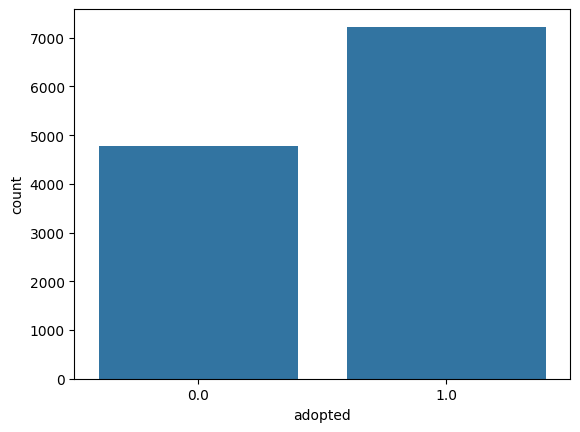

In [12]:
sns.countplot(x='adopted', data=final_df )
plt.show()

In [13]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   user_id                     12000 non-null  int64         
 1   creation_time               12000 non-null  datetime64[ns]
 2   name                        12000 non-null  object        
 3   email                       12000 non-null  object        
 4   creation_source             12000 non-null  object        
 5   last_session_creation_time  8823 non-null   float64       
 6   opted_in_to_mailing_list    12000 non-null  int64         
 7   enabled_for_marketing_drip  12000 non-null  int64         
 8   org_id                      12000 non-null  int64         
 9   invited_by_user_id          6417 non-null   float64       
 10  adopted                     12000 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(4), object(3)


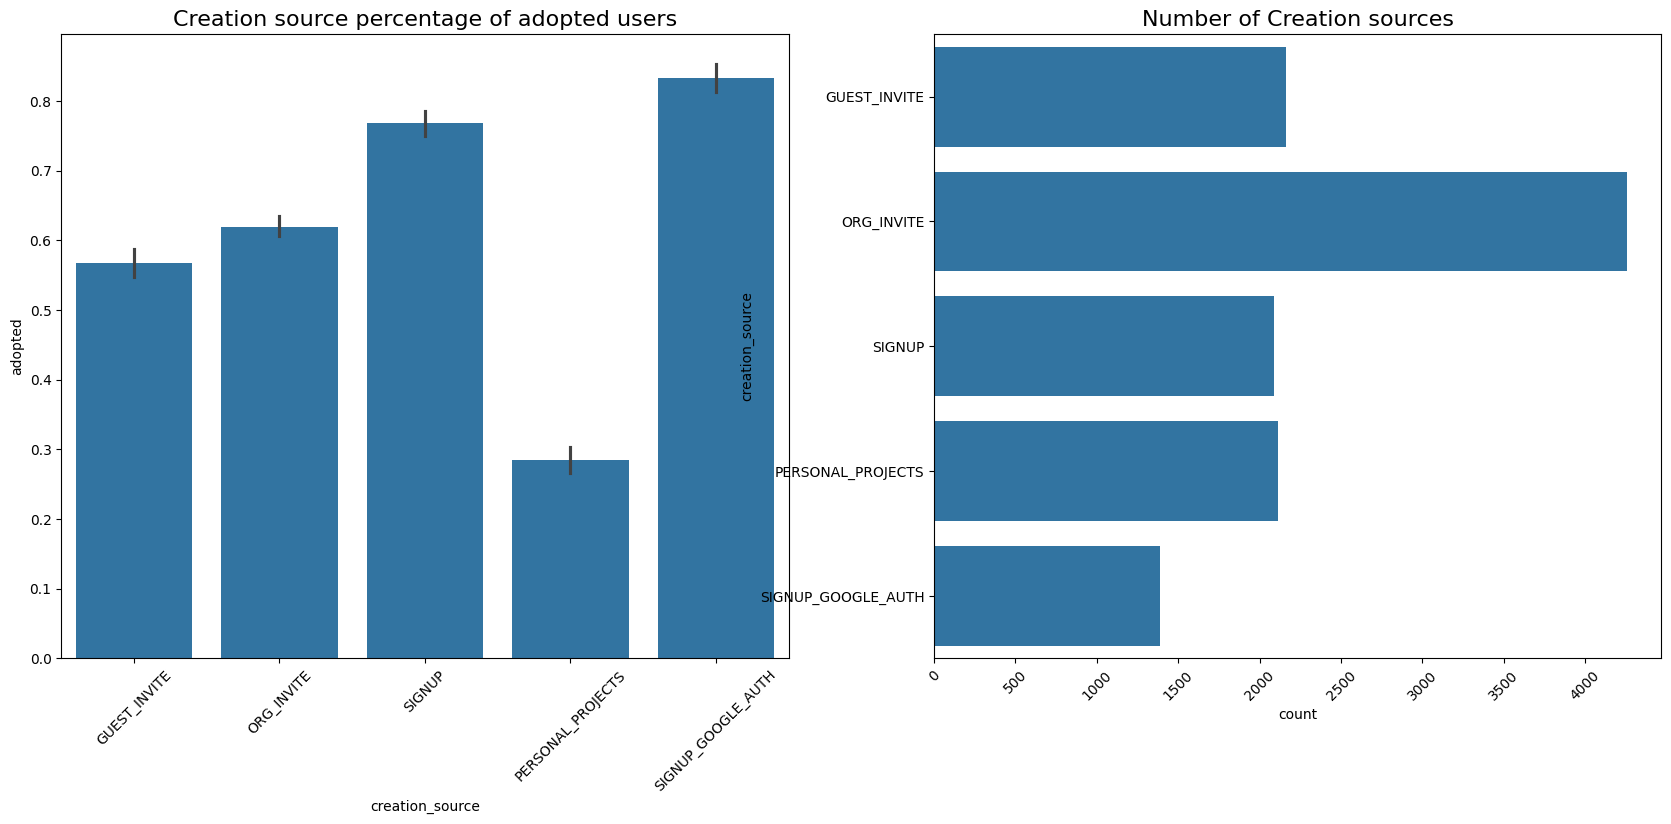

In [14]:
# Creation source percentage of adopted users
plt.subplot(1, 2, 1)
sns.barplot(x="creation_source", y="adopted", data=final_df)
plt.title('Creation source percentage of adopted users', fontsize=16)
plt.xticks(rotation=45)

# countplot creation sources
plt.subplot(1, 2, 2)
sns.countplot(final_df.creation_source)
plt.title('Number of Creation sources', fontsize=16)
plt.xticks(rotation=45)

plt.subplots_adjust(left=0, bottom=-0.3, right=2.5, top=1, wspace=0.2, hspace=0)
plt.show();

In [15]:
# absolute values
final_df[final_df['adopted'] == 1].creation_source.value_counts()

creation_source
ORG_INVITE            2636
SIGNUP                1605
GUEST_INVITE          1229
SIGNUP_GOOGLE_AUTH    1155
PERSONAL_PROJECTS      601
Name: count, dtype: int64

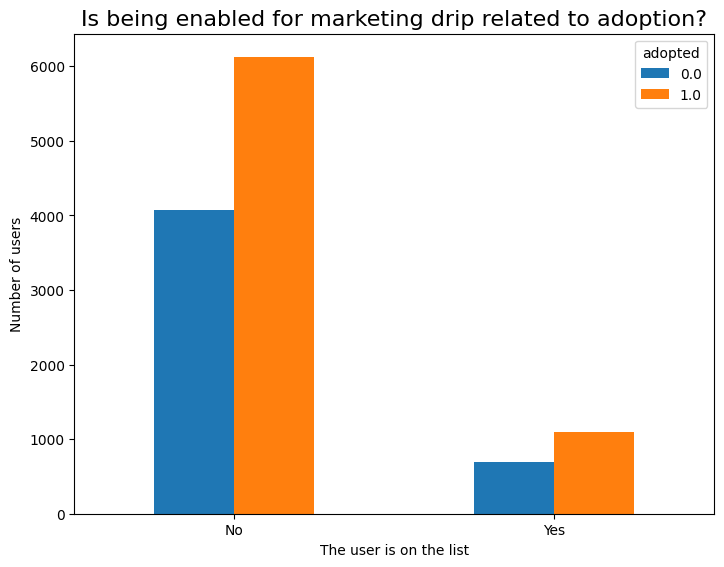

In [16]:
pd.crosstab(final_df['enabled_for_marketing_drip'], final_df['adopted']).plot(kind='bar')
plt.title('Is being enabled for marketing drip related to adoption?', fontsize=16)
plt.xlabel('The user is on the list')
plt.xticks([0, 1], ["No", "Yes"], rotation=0)
plt.ylabel("Number of users")

plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.2, hspace=0)
plt.show()

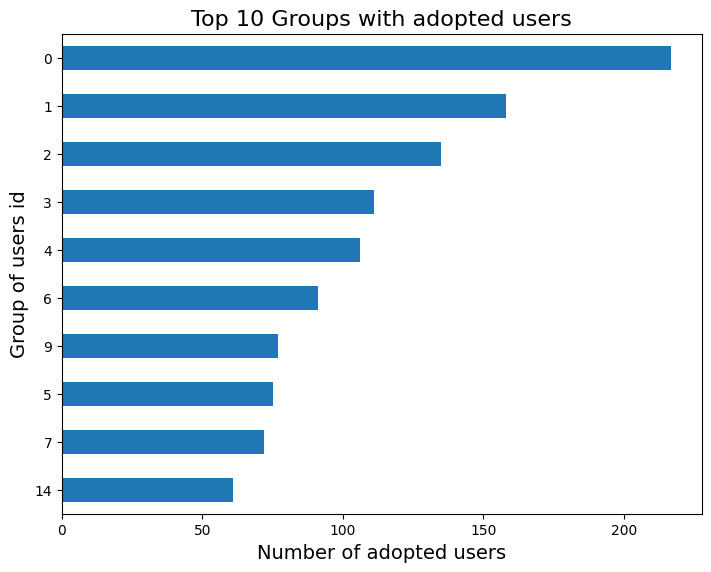

In [17]:
n = 10

# plot top group user id's
final_df[final_df['adopted'] == 1].org_id.value_counts(ascending=True)[-n:].plot(kind='barh')
plt.title("Top {} Groups with adopted users".format(n), fontsize=16)
plt.ylabel("Group of users id", fontsize=14)
plt.xlabel("Number of adopted users", fontsize=14)

plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.2, hspace=0)
plt.show();

In [18]:
# transform the data to operate with - some variables are not relevant for the task
tk_df = final_df.copy().drop(['name', 'email', 'last_session_creation_time', 'user_id', 'invited_by_user_id'],
                                   axis=1)
tk_df['creation_time'] = scale(tk_df['creation_time'])

tk_df = pd.get_dummies(tk_df)
tk_df.head()

c:\Users\pmani\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_data.py:261: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(


,creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,adopted,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH
0,1.290656,1,0,11,1.0,True,False,False,False,False
1,0.561296,0,0,1,0.0,False,True,False,False,False
2,-0.547419,0,0,94,1.0,False,True,False,False,False
3,-0.259511,0,0,1,1.0,True,False,False,False,False
4,-0.831499,0,0,193,1.0,True,False,False,False,False


In [19]:
# binary target
y = tk_df['adopted']

# exclude not relevant features, get dummy variables and normalize
X = tk_df.drop('adopted', axis=1)

# Split into train (70%) and test (30%) sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [20]:
%time
import lightgbm as lgb

# instantiate the model
clf_lgb = lgb.LGBMClassifier(random_state=42, n_estimators=10, class_weight='balanced')

# train the model
clf_lgb.fit(X_train, y_train)

CPU times: total: 0 ns
Wall time: 0 ns
[LightGBM] [Info] Number of positive: 5420, number of negative: 3580
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000211 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 519
[LightGBM] [Info] Number of data points in the train set: 9000, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


LGBMClassifier(class_weight='balanced', n_estimators=10, random_state=42)

In [21]:
model = clf_lgb
model_name = 'LGBMClassifier'

In [22]:

# predict
y_pred = model.predict(X_test)

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

# score
print("Score:", model.score(X_test, y_test))

# Confusion matrix
print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred))

# Classification report
print("\nClassification report:\n", classification_report(y_test, y_pred))

#####################################################

# Compute predicted probabilities: y_pred_prob
y_pred_prob = model.predict_proba(X_test)[:, 1]

# Compute and print AUC score
print("\nAUC: {}".format(roc_auc_score(y_test, y_pred_prob)))

Score: 0.6396666666666667

Confusion matrix:
 [[ 750  444]
 [ 637 1169]]

Classification report:
               precision    recall  f1-score   support

         0.0       0.54      0.63      0.58      1194
         1.0       0.72      0.65      0.68      1806

    accuracy                           0.64      3000
   macro avg       0.63      0.64      0.63      3000
weighted avg       0.65      0.64      0.64      3000


AUC: 0.6967462357932148


# Random Forest Classifier

In [23]:
%time
from sklearn.ensemble import RandomForestClassifier

# instantiate the model
clf_rf = RandomForestClassifier(random_state=42, class_weight='balanced', n_estimators=10)

# train the model
clf_rf.fit(X_train, y_train)

CPU times: total: 0 ns
Wall time: 0 ns


RandomForestClassifier(class_weight='balanced', n_estimators=10,
                       random_state=42)

In [24]:
model = clf_rf
model_name = 'RandomForestClassifier'

In [25]:
# predict
y_pred = model.predict(X_test)

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

# score
print("Score:", model.score(X_test, y_test))

# Confusion matrix
print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred))

# Classification report
print("\nClassification report:\n", classification_report(y_test, y_pred))

#####################################################

# Compute predicted probabilities: y_pred_prob
y_pred_prob = model.predict_proba(X_test)[:, 1]

# Compute and print AUC score
print("\nAUC: {}".format(roc_auc_score(y_test, y_pred_prob)))

Score:

 0.6026666666666667

Confusion matrix:
 [[ 607  587]
 [ 605 1201]]

Classification report:
               precision    recall  f1-score   support

         0.0       0.50      0.51      0.50      1194
         1.0       0.67      0.67      0.67      1806

    accuracy                           0.60      3000
   macro avg       0.59      0.59      0.59      3000
weighted avg       0.60      0.60      0.60      3000


AUC: 0.6274805645058071


# Gradient Boost Classifier

In [26]:
%time
from sklearn.ensemble import GradientBoostingClassifier

# instantiate the model
clf_gb = GradientBoostingClassifier(random_state=42, n_estimators=10)

# train the model
clf_gb.fit(X_train, y_train)

CPU times: total: 0 ns
Wall time: 0 ns


GradientBoostingClassifier(n_estimators=10, random_state=42)

In [27]:
model = clf_gb
model_name = 'GradientBoostingClassifier'

In [28]:
# predict
y_pred = model.predict(X_test)

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

# score
print("Score:", model.score(X_test, y_test))

# Confusion matrix
print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred))

# Classification report
print("\nClassification report:\n", classification_report(y_test, y_pred))

#####################################################

# Compute predicted probabilities: y_pred_prob
y_pred_prob = model.predict_proba(X_test)[:, 1]

# Compute and print AUC score
print("\nAUC: {}".format(roc_auc_score(y_test, y_pred_prob)))

Score: 0.6753333333333333

Confusion matrix:
 [[ 376  818]
 [ 156 1650]]

Classification report:
               precision    recall  f1-score   support

         0.0       0.71      0.31      0.44      1194
         1.0       0.67      0.91      0.77      1806

    accuracy                           0.68      3000
   macro avg       0.69      0.61      0.60      3000
weighted avg       0.68      0.68      0.64      3000


AUC: 0.6924749253836553


# Hyperparameter Tuning

In [29]:
%time
from sklearn.model_selection import RandomizedSearchCV

# we will use all the parameters
gb = GradientBoostingClassifier(n_estimators=300, random_state=44)

# Set the hyperparameter grid of rf
params_gb = {'loss':['exponential', 'log_loss'],
             'criterion': ['friedman_mse', 'squared_error'], 
             'min_samples_split':[2,5,6,7,10,15,100],
             'min_samples_leaf':[1, 2,3,4, 5,6,10],
             'max_features':['sqrt', 'log2',None],             
             'max_depth':[5,8,9,12,15,20,25,30,None]
            }

# RandomizedSearchCV
rs_gb = RandomizedSearchCV(estimator=gb, param_distributions=params_gb, cv=3, n_iter=2 ,n_jobs=-1)

# Fit to the training set
rs_gb.fit(X_train, y_train)      

# Extract best hyperparameters
best_hyperparams = rs_gb.best_params_
print('Best hyperparameters:\n', best_hyperparams)
rs_gb.score(X_test, y_test)


CPU times: total: 0 ns
Wall time: 0 ns
Best hyperparameters:
 {'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': 8, 'loss': 'log_loss', 'criterion': 'squared_error'}


0.6366666666666667

In [30]:
rs_gb.score(X_test, y_test)

0.6366666666666667

In [31]:
tuned_gb = GradientBoostingClassifier(n_estimators=300, min_samples_split= 100, min_samples_leaf= 5, max_features= 'log2', max_depth= None, loss= 'log_loss', criterion= 'squared_error',random_state=42)
tuned_gb.fit(X_train, y_train)

model = tuned_gb
model_name = 'Tuned GradientBoostClassifier'

In [32]:
# predict
y_pred = model.predict(X_test)

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

# score
print("Score:", model.score(X_test, y_test))

# Confusion matrix
print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred))

# Classification report
print("\nClassification report:\n", classification_report(y_test, y_pred))

#####################################################

# Compute predicted probabilities: y_pred_prob
y_pred_prob = model.predict_proba(X_test)[:, 1]

# Compute and print AUC score
print("\nAUC: {}".format(roc_auc_score(y_test, y_pred_prob)))

Score: 0.6103333333333333

Confusion matrix:
 [[ 546  648]
 [ 521 1285]]

Classification report:
               precision    recall  f1-score   support

         0.0       0.51      0.46      0.48      1194
         1.0       0.66      0.71      0.69      1806

    accuracy                           0.61      3000
   macro avg       0.59      0.58      0.59      3000
weighted avg       0.60      0.61      0.61      3000


AUC: 0.6316774440678847


# Extra Trees Classifier

In [34]:
etc = ExtraTreesClassifier(min_samples_split=2,n_estimators=180 )

In [35]:
# predict
etc.fit(X_test, y_test)
y_pred = etc.predict(X_train)


# score
print("Score:", etc.score(X_test, y_test))

# Confusion matrix
print("\nConfusion matrix:\n", confusion_matrix(y_train, y_pred))

# Classification report
print("\nClassification report:\n", classification_report(y_train, y_pred))

#####################################################

# Compute predicted probabilities: y_pred_prob
# y_pred_prob = etc.predict_proba(X_test)[:, 1]

# # Compute and print AUC score
# print("\nAUC: {}".format(roc_auc_score(y_test, y_pred_prob)))

Score: 1.0

Confusion matrix:
 [[1686 1894]
 [1615 3805]]

Classification report:
               precision    recall  f1-score   support

         0.0       0.51      0.47      0.49      3580
         1.0       0.67      0.70      0.68      5420

    accuracy                           0.61      9000
   macro avg       0.59      0.59      0.59      9000
weighted avg       0.61      0.61      0.61      9000



In [36]:
# we will use all the parameters
ex_rs = ExtraTreesClassifier(min_samples_split=2,n_estimators=180 )

# Set the hyperparameter grid of rf
params_gb = {'n_estimators':range(100,200,10), 'min_samples_split':[2,4,6]}
# RandomizedSearchCV
ex_rs = GridSearchCV(estimator=ex_rs, param_grid=params_gb, cv=5,n_jobs=-1)

# Fit to the training set
ex_rs.fit(X_train, y_train)      

# Extract best hyperparameters
best_hyperparams = ex_rs.best_params_
print('Best hyperparameters:\n', best_hyperparams)

ex_rs.score(X_test, y_test)

Best hyperparameters:
 {'min_samples_split': 6, 'n_estimators': 130}


0.6383333333333333

In [37]:
model = ex_rs

In [38]:
# predict
y_pred = model.predict(X_test)

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

# score
print("Score:", model.score(X_test, y_test))

# Confusion matrix
print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred))

# Classification report
print("\nClassification report:\n", classification_report(y_test, y_pred))

#####################################################

# Compute predicted probabilities: y_pred_prob
y_pred_prob = model.predict_proba(X_test)[:, 1]

# Compute and print AUC score
print("\nAUC: {}".format(roc_auc_score(y_test, y_pred_prob)))


Score: 0.6383333333333333

Confusion matrix:
 [[ 506  688]
 [ 397 1409]]

Classification report:
               precision    recall  f1-score   support

         0.0       0.56      0.42      0.48      1194
         1.0       0.67      0.78      0.72      1806

    accuracy                           0.64      3000
   macro avg       0.62      0.60      0.60      3000
weighted avg       0.63      0.64      0.63      3000


AUC: 0.6573472753208642


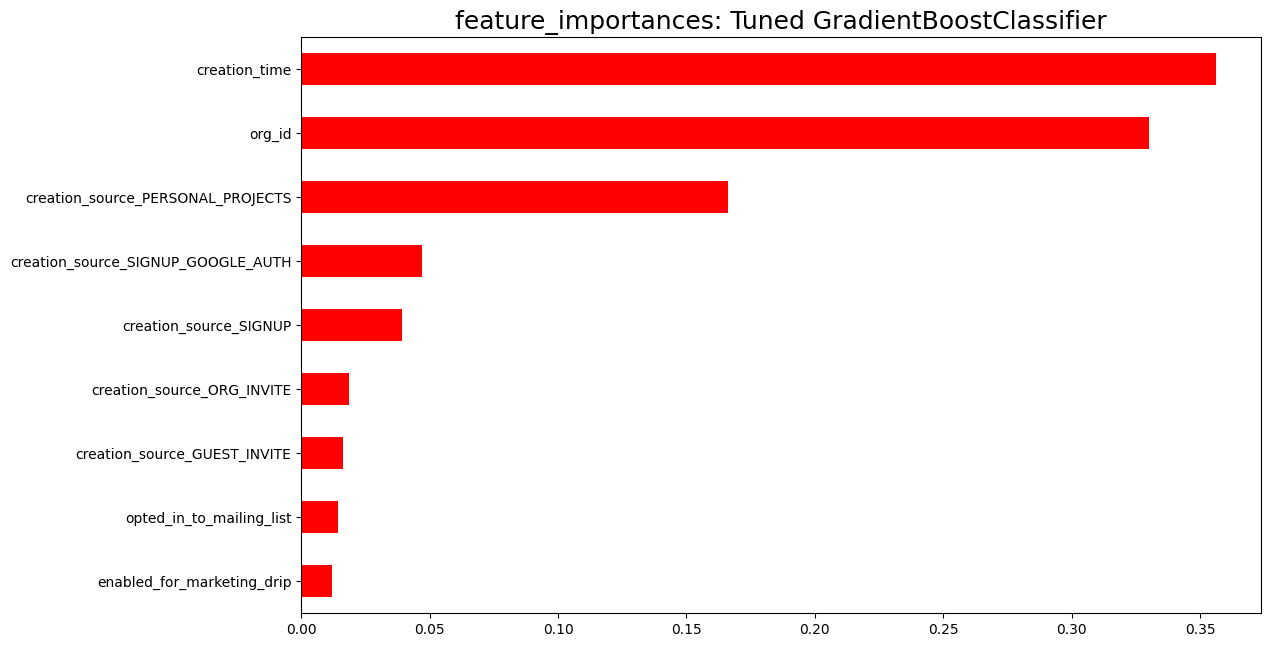

In [39]:
# X columns
X_columns = X.columns

# Create a pd.Series of features feature_importances
feature_importances = pd.Series(data=model.best_estimator_.feature_importances_, index=X_columns)

# Sort feature_importances
feature_importances_sorted = feature_importances.sort_values()

# Draw a horizontal barplot of feature_importances_sorted
feature_importances_sorted.tail(100).plot(kind='barh', color='red')
plt.title('feature_importances: {}'.format(model_name), fontsize=18)
plt.subplots_adjust(left=0, bottom=-0.2, right=1.5, top=1, wspace=0, hspace=0)
plt.show();